# Imports

In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

print(tf.__version__)

2.6.4


# Setting dataset directory

In [2]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = '../input/covid19-image-dataset/Covid19-dataset/train'
TESTING_DIR = '../input/covid19-image-dataset/Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


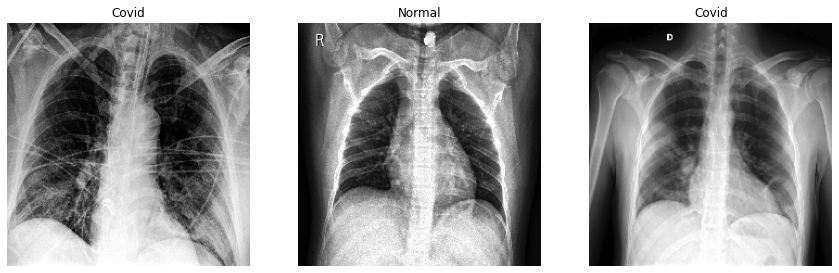

In [3]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,3)

In [4]:
BATCH_SIZE: int = 1
EPOCHS: int = 5
IMAGE_SIZE = (224, 224)
input_shape =(224,224,3)
AUGMENTATION_FACTOR: float = 0.2
LABEL_MODE: str = "binary"
TRAIN_DIR: str = "/kaggle/input/covid19-image-dataset/Covid19-dataset/train"
TEST_DIR: str = "/kaggle/input/covid19-image-dataset/Covid19-dataset/test"
RANDOM_SEED: int = 42

In [5]:
class_names = os.listdir(TRAIN_DIR)
class_names

['Normal', 'Viral Pneumonia', 'Covid']

In [6]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

2022-12-22 08:47:51.331084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 08:47:51.332027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 08:47:51.469345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 08:47:51.470358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 08:47:51.471161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________

In [7]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

2022-12-22 08:47:58.264066: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-22 08:48:02.995338: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4/4 [==============================] - 42s 7s/step - loss: 1.2078 - acc: 0.3865 - val_loss: 1.0450 - val_acc: 0.3939

Epoch 00001: acc improved from -inf to 0.38645, saving model to model/vgg16_best.h5
Epoch 2/50
4/4 [==============================] - 13s 3s/step - loss: 1.1162 - acc: 0.4343 - val_loss: 0.9682 - val_acc: 0.3939

Epoch 00002: acc improved from 0.38645 to 0.43426, saving model to model/vgg16_best.h5
Epoch 3/50
4/4 [==============================] - 12s 3s/step - loss: 0.9845 - acc: 0.5219 - val_loss: 0.8984 - val_acc: 0.6515

Epoch 00003: acc improved from 0.43426 to 0.52191, saving model to model/vgg16_best.h5
Epoch 4/50
4/4 [==============================] - 13s 3s/step - loss: 0.9071 - acc: 0.5339 - val_loss: 0.8215 - val_acc: 0.7424

Epoch 00004: acc improved from 0.52191 to 0.53386, saving model to model/vgg16_best.h5
Epoch 5/50
4/4 [==============================] - 12s 3s/step - loss: 0.8382 - acc: 0.6414 - val_loss: 0.7378 - val_acc: 0.7879

Epoch 00005: acc impr

# Plotting the Curves

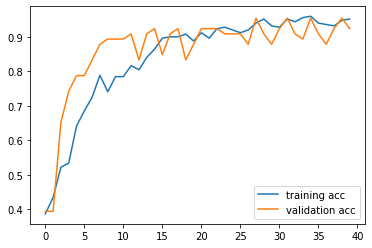

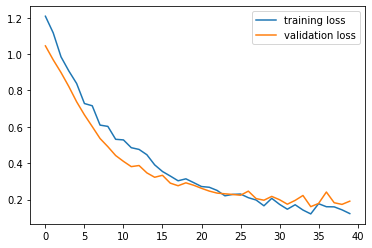

In [8]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

# Evaluation

In [9]:
model_vgg16.evaluate(test_generator)

2/2 [==============================] - 2s 22ms/step - loss: 0.1615 - acc: 0.9545


[0.16150565445423126, 0.9545454382896423]

                 precision    recall  f1-score   support

         Normal       0.90      0.95      0.93        20
Viral Pneumonia       0.95      0.90      0.92        20
          Covid       1.00      1.00      1.00        26

       accuracy                           0.95        66
      macro avg       0.95      0.95      0.95        66
   weighted avg       0.96      0.95      0.95        66



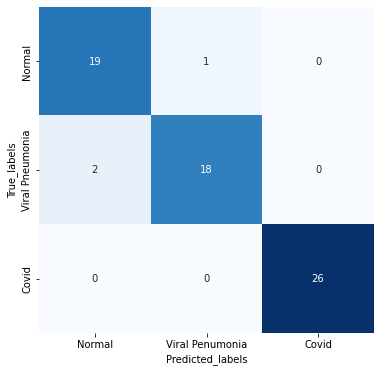

In [10]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=class_names)  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred, target_names=class_names))

# Random Prediction

In [11]:
def load_and_prep_image(filename):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, list(IMAGE_SIZE))
    return img/255.

In [12]:
import random
def make_random_prediction(class_names, test_dir, qty: int = 3, figsize =(17, 10), fontsize: int = 12):
    plt.figure(figsize=figsize)
    for i in range(qty):
        # Choose random image(s) from random class(es)
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(test_dir + "/" + class_name))
        filepath = test_dir + "/" + class_name + "/" + filename
        
        # Load the image and make predictions
        print("filepath:", filepath)
        img = load_and_prep_image(filepath)
        print("before:", img.shape)
        img_expanded = tf.expand_dims(img, axis=0)
        print("after: ", img_expanded.shape)
        pred_prob = model_vgg16.predict(img_expanded) # get prediction probabilities array
        pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list

        # Plot the image(s)
        plt.subplot(1, qty, i+1)
        # print(img)
        plt.imshow(img)
        if class_name == pred_class: # if predicted class matches truth class, make text green
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color, fontdict= {'fontsize': fontsize})
        plt.axis(False);

filepath: /kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0102.jpeg
before: (224, 224, 3)
after:  (1, 224, 224, 3)
filepath: /kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0105.jpeg
before: (224, 224, 3)
after:  (1, 224, 224, 3)
filepath: /kaggle/input/covid19-image-dataset/Covid19-dataset/test/Viral Pneumonia/0107.jpeg
before: (224, 224, 3)
after:  (1, 224, 224, 3)


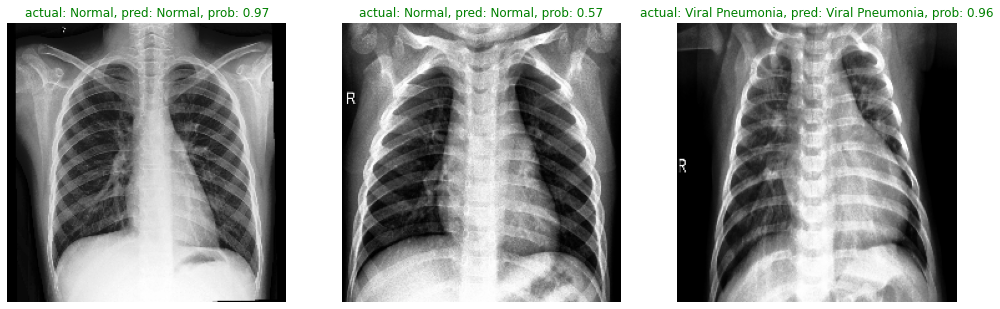

In [13]:
make_random_prediction(class_names, test_dir="/kaggle/input/covid19-image-dataset/Covid19-dataset/test")